# Quantization work for ViT 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import vit_l_32 

In [2]:
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision import datasets


import os
import tensorrt as trt
import numpy as np
import time
import wget
import tarfile
import shutil
from tqdm import tqdm

## 2 Setup a baseline ViT model 


### Preparing the Dataset 

We use imagenet-mini to quantize and evaluate the ViT model. You can download the dataset using 

```shell
#!/bin/bash
curl -L -o ~/Downloads/imagenetmini-1000.zip\
  https://www.kaggle.com/api/v1/datasets/download/ifigotin/imagenetmini-1000)
```

In [3]:
DATA_DIR = "./data/imagenet-mini"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")

In [4]:
# Performing Transformations on the dataset and defining training and validation dataloaders
transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            ])
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform)

sum = 0
for cls in train_dataset.classes:
    cls_count = len(os.listdir(os.path.join(TRAIN_DIR, cls)))
    sum += cls_count
print(f"Total training samples: {sum}")

# split validation dataset into calibration and validation sets
calib_dataset = torch.utils.data.random_split(val_dataset, [50, len(val_dataset) - 50])[0]

# pin memory for faster data transfer to GPU, and use multiple workers to speed up data loading
train_dataloader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_dataloader = data.DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True, pin_memory=True, num_workers=2)
calib_dataloader = data.DataLoader(calib_dataset, batch_size=64, shuffle=False, drop_last=True, pin_memory=True, num_workers=2)

Total training samples: 34745


tensor(0)


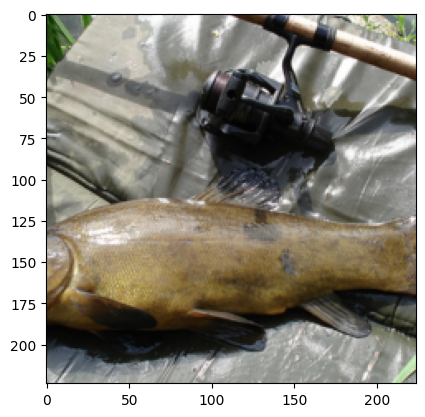

In [5]:
import matplotlib.pyplot as plt 
for images, labels in val_dataloader:
    print(labels[0])
    image = images[0]
    img = image.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img)
    break

In [6]:
# Define functions for training, evalution, saving checkpoint and train parameter setting function
import torch.backends.cudnn as cudnn
def train(model, dataloader, crit, opt, epoch):
    model.train()
    running_loss = 0.0
    for batch, (data, labels) in enumerate(dataloader):
        data, labels = data.cuda(), labels.cuda(non_blocking=True)
        opt.zero_grad()
        out = model(data)
        loss = crit(out, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        if batch % 100 == 99:
            print("Batch: [%5d | %5d] loss: %.3f" % (batch + 1, len(dataloader), running_loss / 100))
            running_loss = 0.0
        
def evaluate(model, dataloader, crit, epoch):
    total = 0
    correct = 0
    loss = 0.0
    model.eval()
    start_time = time.perf_counter()  # ⏱️ 开始计时

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.cuda(), labels.cuda(non_blocking=True)
            out = model(data)
            loss += crit(out, labels).item()
            preds = torch.max(out, 1)[1]
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    elapsed = time.perf_counter() - start_time  # ⏱️ 结束计时
    accuracy = correct / total
    print(f"✅ Accuracy: {accuracy:.4f}, Time: {elapsed:.2f}s")
    return accuracy

def save_checkpoint(state, ckpt_path="checkpoint.pth"):
    torch.save(state, ckpt_path)
    print("Checkpoint saved")
    
# Helper function to benchmark the model
cudnn.benchmark = True
def benchmark(model, input_shape=(1024, 1, 32, 32), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            output = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)

    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

In [7]:
model = vit_l_32(pretrained=True)

# Declare Learning rate
lr = 0.0001

# Use cross entropy loss for classification and SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_L_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# train for 8 epochs

model = model.cuda()

num_epochs=8
for epoch in range(num_epochs):
    print('Epoch: [%5d / %5d] LR: %f' % (epoch + 1, num_epochs, lr))

    train(model, train_dataloader, criterion, optimizer, epoch)
    test_acc = evaluate(model, val_dataloader, criterion, epoch)

    print("Test Acc: {:.2f}%".format(100 * test_acc))


save_checkpoint({'epoch': epoch + 1,
                 'model_state_dict': model.state_dict(),
                 'acc': test_acc,
                 'opt_state_dict': optimizer.state_dict()
                },
                ckpt_path="models/vit_l_32_base.pth")

Epoch: [    1 /     8] LR: 0.000100
Batch: [  100 |   542] loss: 0.813
Batch: [  200 |   542] loss: 0.577
Batch: [  300 |   542] loss: 0.518
Batch: [  400 |   542] loss: 0.469
Batch: [  500 |   542] loss: 0.461
✅ Accuracy: 0.7364, Time: 8.91s
Test Acc: 73.64%
Epoch: [    2 /     8] LR: 0.000100
Batch: [  100 |   542] loss: 0.413
Batch: [  200 |   542] loss: 0.434
Batch: [  300 |   542] loss: 0.400
Batch: [  400 |   542] loss: 0.404
Batch: [  500 |   542] loss: 0.393
✅ Accuracy: 0.7385, Time: 8.72s
Test Acc: 73.85%
Epoch: [    3 /     8] LR: 0.000100
Batch: [  100 |   542] loss: 0.376
Batch: [  200 |   542] loss: 0.381
Batch: [  300 |   542] loss: 0.376
Batch: [  400 |   542] loss: 0.367
Batch: [  500 |   542] loss: 0.378
✅ Accuracy: 0.7433, Time: 8.96s
Test Acc: 74.33%
Epoch: [    4 /     8] LR: 0.000100
Batch: [  100 |   542] loss: 0.365
Batch: [  200 |   542] loss: 0.364
Batch: [  300 |   542] loss: 0.358
Batch: [  400 |   542] loss: 0.340
Batch: [  500 |   542] loss: 0.354
✅ Accurac

In [9]:
# Evaluate the baseline model
test_acc = evaluate(model, val_dataloader, criterion, 0)
print("Mobilenetv2 Baseline accuracy: {:.2f}%".format(100 * test_acc))

✅ Accuracy: 0.7482, Time: 8.95s
Mobilenetv2 Baseline accuracy: 74.82%


In [10]:
# Exporting to Onnx
dummy_input = next(iter(val_dataloader))[0].cuda()
input_names = [ "actual_input_1" ]
output_names = [ "output1" ]
torch.onnx.export(
    model,
    dummy_input,
    "models/vit_l_32_base.onnx",
    opset_version=19,
    do_constant_folding = False,
    dynamo=True
    )

# Converting ONNX model to TRT
!trtexec --onnx=models/vit_l_32_base.onnx --saveEngine=models/vit_l_32_base.trt

[torch.onnx] Obtain model graph for `VisionTransformer([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `VisionTransformer([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 25 of general pattern rewrite rules.
&&&& RUNNING TensorRT.trtexec [TensorRT v101303] [b9] # trtexec --onnx=models/vit_l_32_base.onnx --saveEngine=models/vit_l_32_base.trt
[10/29/2025-17:13:17] [I] TF32 is enabled by default. Add --noTF32 flag to further improve accuracy with some performance cost.
[10/29/2025-17:13:17] [I] === Model Options ===
[10/29/2025-17:13:17] [I] Format: ONNX
[10/29/2025-17:13:17] [I] Model: models/vit_l_32_base.onnx
[10/29/2025-17:13:17] [I] Output:
[10/29/2025-17:13:17] [I] === Build Options ===
[10/29/2025-17:13:17] [I] Memory Pools: workspace: default, dlaSRAM: default

## PTQ 

In [11]:
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib
# 初始化 pytorch_quantization
quant_modules.initialize()

In [12]:
q_model = vit_l_32(pretrained=False)

ckpt = torch.load("models/vit_l_32_base.pth")
q_model.load_state_dict(ckpt['model_state_dict'])
optimizer.load_state_dict(ckpt['opt_state_dict'])

# load pretrained weights

print(q_model)

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): QuantConv2d(
    3, 1024, kernel_size=(32, 32), stride=(32, 32)
    (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
    (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): QuantLinear(
            in_features=1024, out_features=4096, bias=True
            (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dy

In [13]:
def compute_amax(model, **kwargs):
    # Load calib result
    for name, module in model.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if module._calibrator is not None:
                if isinstance(module._calibrator, calib.MaxCalibrator):
                    module.load_calib_amax()
                else:
                    module.load_calib_amax(**kwargs)
    model.cuda()

def collect_stats(model, data_loader, num_batches):
    """Feed data to the network and collect statistics"""
    # Enable calibrators
    for name, module in model.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if module._calibrator is not None:
                module.disable_quant()
                module.enable_calib()
            else:
                module.disable()

    # Feed data to the network for collecting stats
    for i, (image, _) in tqdm(enumerate(data_loader), total=num_batches):
        model(image.cuda())
        if i >= num_batches:
            break

    # Disable calibrators
    for name, module in model.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if module._calibrator is not None:
                module.enable_quant()
                module.disable_calib()
            else:
                module.enable()

In [14]:
q_model = q_model.cuda()

# Calibrate the model using max calibration technique.
with torch.no_grad():
    collect_stats(q_model, train_dataloader, num_batches=16)
    compute_amax(q_model, method="max")

100%|██████████| 16/16 [00:01<00:00, 11.38it/s]
W1029 17:13:47.155898 140399043684160 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 17:13:47.157437 140399043684160 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 17:13:47.158496 140399043684160 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 17:13:47.159316 140399043684160 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 17:13:47.160160 140399043684160 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 17:13:47.160887 140399043684160 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 17:13:47.161659 140399043684160 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 17:13:47.162353 140399043684160 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 17:13:47.163070 140399043684160 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 17:13:47.163792 140399043684160 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 17:13:47.164558 140399043684160 tensor_quantizer.py:174] Disable MaxCalibrator
W1029 17:13:47.16

In [15]:
import torch
import matplotlib.pyplot as plt
from pytorch_quantization import nn as quant_nn

def visualize_quant_params(model, plot_hist=False, max_layers=10):
    """
    可视化量化层的权重与激活范围 (amax, scale)
    """
    layer_idx = 0
    for name, module in model.named_modules():
        if isinstance(module, (quant_nn.QuantLinear, quant_nn.QuantConv2d)):
            print(f"\n📦 Layer: {name}")

            # 权重量化参数
            if module._weight_quantizer._calibrator is not None:
                w_amax = module._weight_quantizer._calibrator._calib_amax
                if w_amax is not None:
                    w_scale = w_amax / 127.0
                    print(f"  [Weight] amax={w_amax.detach().cpu().numpy()}, scale={w_scale.detach().cpu().numpy()}")
                else:
                    print("  [Weight] No amax collected yet.")
            else:
                print("  [Weight] No calibrator info found.")

            # 激活量化参数
            if module._input_quantizer._calibrator is not None:
                a_amax = module._input_quantizer._calibrator._calib_amax
                if a_amax is not None:
                    a_scale = a_amax / 127.0
                    print(f"  [Activation] amax={a_amax.detach().cpu().numpy()}, scale={a_scale.detach().cpu().numpy()}")
                else:
                    print("  [Activation] No amax collected yet.")
            else:
                print("  [Activation] No calibrator info found.")

            # 绘制权重分布
            if plot_hist and layer_idx < max_layers:
                w = module.weight.detach().flatten().cpu().numpy()
                plt.figure(figsize=(5, 3))
                plt.hist(w, bins=100, color='royalblue', alpha=0.7)
                plt.title(f"{name}\nWeight Distribution")
                plt.xlabel("Weight Value")
                plt.ylabel("Frequency")
                plt.grid(True, linestyle='--', alpha=0.4)
                plt.show()

            layer_idx += 1

    print("\n✅ 完成量化参数可视化。")



📦 Layer: conv_proj
  [Weight] amax=[[[[0.09148958]]]


 [[[0.08686049]]]


 [[[0.00596003]]]


 ...


 [[[0.00755835]]]


 [[[0.00829288]]]


 [[[0.00454627]]]], scale=[[[[7.2039035e-04]]]


 [[[6.8394089e-04]]]


 [[[4.6929370e-05]]]


 ...


 [[[5.9514579e-05]]]


 [[[6.5298300e-05]]]


 [[[3.5797388e-05]]]]
  [Activation] amax=1.0, scale=0.007874015718698502


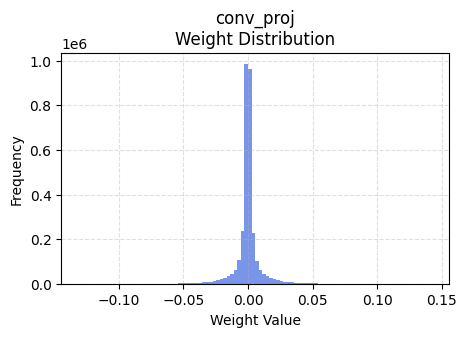


📦 Layer: encoder.layers.encoder_layer_0.mlp.0
  [Weight] amax=[[0.22775334]
 [0.23772812]
 [0.09046029]
 ...
 [0.22953609]
 [0.1895582 ]
 [0.17220348]], scale=[[0.00179333]
 [0.00187187]
 [0.00071229]
 ...
 [0.00180737]
 [0.00149258]
 [0.00135593]]
  [Activation] amax=7.6980156898498535, scale=0.060614295303821564


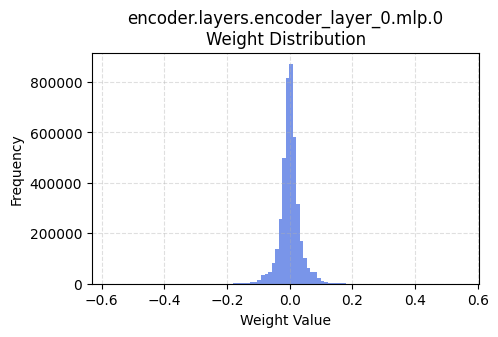


📦 Layer: encoder.layers.encoder_layer_0.mlp.3
  [Weight] amax=[[0.21135615]
 [0.21296409]
 [0.03432702]
 ...
 [0.04613386]
 [0.03456732]
 [0.02840851]], scale=[[0.00166422]
 [0.00167688]
 [0.00027029]
 ...
 [0.00036326]
 [0.00027218]
 [0.00022369]]
  [Activation] amax=8.055439949035645, scale=0.06342866271734238


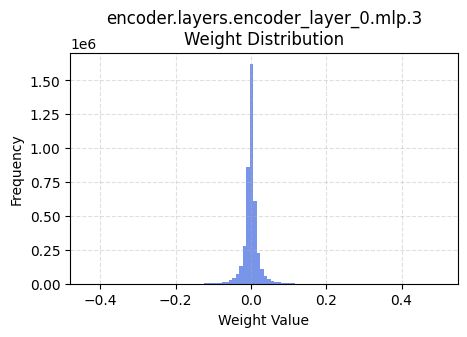


📦 Layer: encoder.layers.encoder_layer_1.mlp.0
  [Weight] amax=[[0.16082218]
 [0.17957224]
 [0.28875482]
 ...
 [0.20912234]
 [0.14900094]
 [0.14459778]], scale=[[0.00126632]
 [0.00141395]
 [0.00227366]
 ...
 [0.00164663]
 [0.00117324]
 [0.00113857]]
  [Activation] amax=7.949042797088623, scale=0.06259088963270187


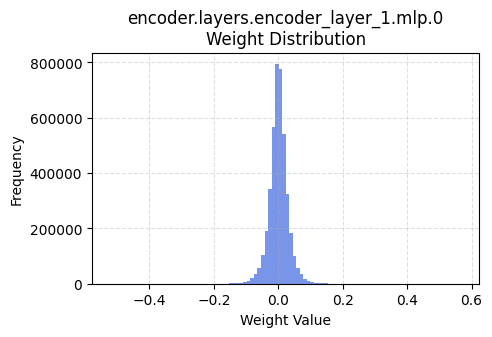


📦 Layer: encoder.layers.encoder_layer_1.mlp.3
  [Weight] amax=[[0.10339656]
 [0.15040818]
 [0.04477871]
 ...
 [0.04787847]
 [0.06135802]
 [0.05671934]], scale=[[0.00081415]
 [0.00118432]
 [0.00035259]
 ...
 [0.000377  ]
 [0.00048313]
 [0.00044661]]
  [Activation] amax=5.954206466674805, scale=0.046883516013622284


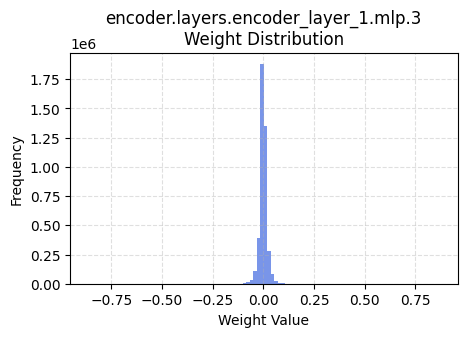


📦 Layer: encoder.layers.encoder_layer_2.mlp.0
  [Weight] amax=[[0.13949196]
 [0.13078152]
 [0.11090567]
 ...
 [0.19521934]
 [0.15850165]
 [0.1278966 ]], scale=[[0.00109836]
 [0.00102978]
 [0.00087327]
 ...
 [0.00153716]
 [0.00124804]
 [0.00100706]]
  [Activation] amax=6.126917362213135, scale=0.0482434444129467


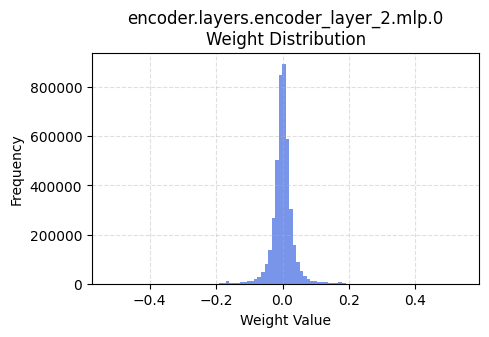


📦 Layer: encoder.layers.encoder_layer_2.mlp.3
  [Weight] amax=[[0.12073235]
 [0.1727264 ]
 [0.04039486]
 ...
 [0.06954467]
 [0.07333177]
 [0.03050905]], scale=[[0.00095065]
 [0.00136005]
 [0.00031807]
 ...
 [0.0005476 ]
 [0.00057742]
 [0.00024023]]
  [Activation] amax=3.9151828289031982, scale=0.030828211456537247


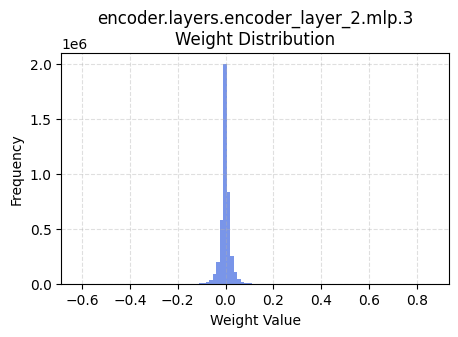


📦 Layer: encoder.layers.encoder_layer_3.mlp.0
  [Weight] amax=[[0.13715358]
 [0.17781653]
 [0.13082972]
 ...
 [0.19850732]
 [0.1389247 ]
 [0.14365941]], scale=[[0.00107995]
 [0.00140013]
 [0.00103016]
 ...
 [0.00156305]
 [0.0010939 ]
 [0.00113118]]
  [Activation] amax=6.4971604347229, scale=0.05115874484181404


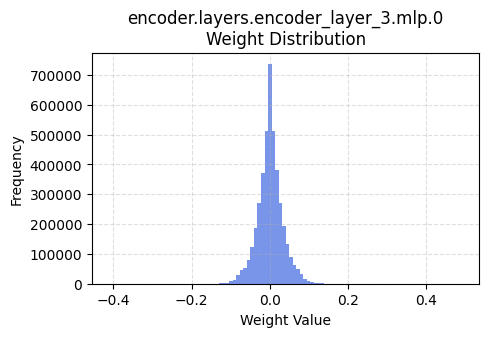


📦 Layer: encoder.layers.encoder_layer_3.mlp.3
  [Weight] amax=[[0.08860792]
 [0.17700434]
 [0.06008339]
 ...
 [0.06887737]
 [0.09055902]
 [0.0411858 ]], scale=[[0.0006977 ]
 [0.00139373]
 [0.0004731 ]
 ...
 [0.00054234]
 [0.00071306]
 [0.0003243 ]]
  [Activation] amax=5.2981181144714355, scale=0.041717465966939926


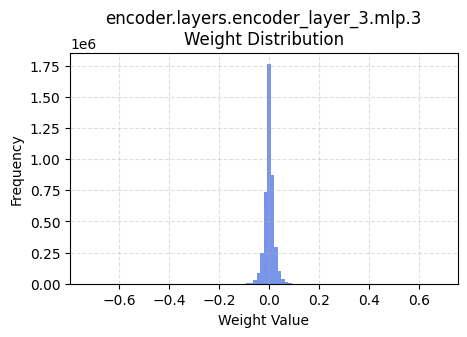


📦 Layer: encoder.layers.encoder_layer_4.mlp.0
  [Weight] amax=[[0.25120267]
 [0.15740968]
 [0.1333155 ]
 ...
 [0.12296902]
 [0.1369171 ]
 [0.15153953]], scale=[[0.00197797]
 [0.00123945]
 [0.00104973]
 ...
 [0.00096826]
 [0.00107809]
 [0.00119322]]
  [Activation] amax=5.289857387542725, scale=0.04165241867303848


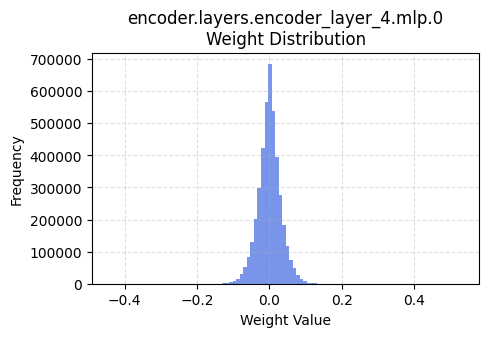


📦 Layer: encoder.layers.encoder_layer_4.mlp.3
  [Weight] amax=[[0.09186395]
 [0.12288424]
 [0.05800125]
 ...
 [0.07695053]
 [0.07794526]
 [0.03942106]], scale=[[0.00072334]
 [0.00096759]
 [0.0004567 ]
 ...
 [0.00060591]
 [0.00061374]
 [0.0003104 ]]
  [Activation] amax=4.405224800109863, scale=0.03468680754303932

📦 Layer: encoder.layers.encoder_layer_5.mlp.0
  [Weight] amax=[[0.15796573]
 [0.1632154 ]
 [0.11388458]
 ...
 [0.14084145]
 [0.11428846]
 [0.13419436]], scale=[[0.00124382]
 [0.00128516]
 [0.00089673]
 ...
 [0.00110899]
 [0.00089991]
 [0.00105665]]
  [Activation] amax=5.983667373657227, scale=0.04711548984050751

📦 Layer: encoder.layers.encoder_layer_5.mlp.3
  [Weight] amax=[[0.11455752]
 [0.11519537]
 [0.0743408 ]
 ...
 [0.08691892]
 [0.10238694]
 [0.03713597]], scale=[[0.00090203]
 [0.00090705]
 [0.00058536]
 ...
 [0.0006844 ]
 [0.0008062 ]
 [0.00029241]]
  [Activation] amax=5.230605602264404, scale=0.04118587076663971

📦 Layer: encoder.layers.encoder_layer_6.mlp.0
  [Weigh

In [16]:
visualize_quant_params(q_model, plot_hist=True, max_layers=10)

In [17]:
# Evaluate the baseline model
test_ptq_acc = evaluate(q_model, val_dataloader, criterion, 0)
print("Vit_l_32 PTQ accuracy: {:.2f}%".format(100 * test_ptq_acc))

✅ Accuracy: 0.7456, Time: 9.14s
Vit_l_32 PTQ accuracy: 74.56%


In [18]:
# save the ptq model 
torch.save(q_model.state_dict(), "models/vit_l_32_ptq.pth")

In [19]:
# Set static member of TensorQuantizer to use Pytorch’s own fake quantization functions
quant_nn.TensorQuantizer.use_fb_fake_quant = True

# Exporting to ONNX
dummy_input = next(iter(val_dataloader))[0].cuda()
input_names = [ "actual_input_1" ]
output_names = [ "output1" ]
torch.onnx.export(
    q_model,
    dummy_input,
    "models/vit_l_32_ptq.onnx",
    opset_version=19,
    do_constant_folding = False,
    dynamo=False
    )

# Converting ONNX model to TRT
!trtexec --onnx=models/vit_l_32_ptq.onnx --int8 --saveEngine=models/vit_l_32_ptq.trt

/tmp/ipykernel_64043/2127241644.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
/root/miniconda3/lib/python3.12/site-packages/torch/__init__.py:2174: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message

&&&& RUNNING TensorRT.trtexec [TensorRT v101303] [b9] # trtexec --onnx=models/vit_l_32_ptq.onnx --int8 --saveEngine=models/vit_l_32_ptq.trt
[10/29/2025-17:14:08] [I] === Model Options ===
[10/29/2025-17:14:08] [I] Format: ONNX
[10/29/2025-17:14:08] [I] Model: models/vit_l_32_ptq.onnx
[10/29/2025-17:14:08] [I] Output:
[10/29/2025-17:14:08] [I] === Build Options ===
[10/29/2025-17:14:08] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default, tacticSharedMem: default
[10/29/2025-17:14:08] [I] avgTiming: 8
[10/29/2025-17:14:08] [I] Precision: FP32+INT8
[10/29/2025-17:14:08] [I] LayerPrecisions: 
[10/29/2025-17:14:08] [I] Layer Device Types: 
[10/29/2025-17:14:08] [I] Calibration: Dynamic
[10/29/2025-17:14:08] [I] Refit: Disabled
[10/29/2025-17:14:08] [I] Strip weights: Disabled
[10/29/2025-17:14:08] [I] Version Compatible: Disabled
[10/29/2025-17:14:08] [I] ONNX Plugin InstanceNorm: Disabled
[10/29/2025-17:14:08] [I] ONNX kENABLE_UINT8_AND_AS

## QAT

PTQ resulted in a ~4% accuracy drop compared to the baseline FP32 model. To further improve the accuracy, we can use QAT to finetune the quantized model. The following code snippet shows how to perform QAT using `pytorch-quantization`

In [20]:
lr = 8e-5
num_epochs = 5 # fine-tune for 5 epochs with quantizzation noise

optimizer = optim.SGD(q_model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)


for epoch in range(num_epochs):
    print('Epoch: [%5d / %5d] LR: %f' % (epoch + 1, num_epochs, lr))

    train(q_model, train_dataloader, criterion, optimizer, epoch)
    test_acc = evaluate(q_model, val_dataloader, criterion, epoch)

    print("Test Accuracy after epoch %d: %.2f%%" % (epoch + 1, 100 * test_acc))

Epoch: [    1 /     5] LR: 0.000080
Batch: [  100 |   542] loss: 0.341
Batch: [  200 |   542] loss: 0.313
Batch: [  300 |   542] loss: 0.327
Batch: [  400 |   542] loss: 0.312
Batch: [  500 |   542] loss: 0.303
✅ Accuracy: 0.7490, Time: 9.12s
Test Accuracy after epoch 1: 74.90%
Epoch: [    2 /     5] LR: 0.000080
Batch: [  100 |   542] loss: 0.278
Batch: [  200 |   542] loss: 0.277
Batch: [  300 |   542] loss: 0.278
Batch: [  400 |   542] loss: 0.270
Batch: [  500 |   542] loss: 0.279
✅ Accuracy: 0.7515, Time: 8.92s
Test Accuracy after epoch 2: 75.15%
Epoch: [    3 /     5] LR: 0.000080
Batch: [  100 |   542] loss: 0.252
Batch: [  200 |   542] loss: 0.249
Batch: [  300 |   542] loss: 0.255
Batch: [  400 |   542] loss: 0.261
Batch: [  500 |   542] loss: 0.244
✅ Accuracy: 0.7508, Time: 9.24s
Test Accuracy after epoch 3: 75.08%
Epoch: [    4 /     5] LR: 0.000080
Batch: [  100 |   542] loss: 0.239
Batch: [  200 |   542] loss: 0.229
Batch: [  300 |   542] loss: 0.247
Batch: [  400 |   542]

In [21]:
test_qat_acc = evaluate(q_model, val_dataloader, criterion, 0)
print("Vit_l_32 QAT accuracy: {:.2f}%".format(100 * test_qat_acc))

✅ Accuracy: 0.7467, Time: 9.38s
Vit_l_32 QAT accuracy: 74.67%


In [22]:
# save the weights
torch.save(q_model.state_dict(), "models/vit_l_32_qat.pth")

In [23]:
# Set static member of TensorQuantizer to use Pytorch’s own fake quantization functions
quant_nn.TensorQuantizer.use_fb_fake_quant = True

# Exporting to ONNX
dummy_input = next(iter(val_dataloader))[0].cuda()
input_names = [ "actual_input_1" ]
output_names = [ "output1" ]
torch.onnx.export(
    q_model,
    dummy_input,
    "models/vit_l_32_qat.onnx",
    opset_version=19,
    do_constant_folding = False,
    dynamo=False
    )

# Converting ONNX model to TRT
!trtexec --onnx=models/vit_l_32_qat.onnx --int8 --saveEngine=models/vit_l_32_qat.trt

/tmp/ipykernel_64043/1073773642.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


&&&& RUNNING TensorRT.trtexec [TensorRT v101303] [b9] # trtexec --onnx=models/vit_l_32_qat.onnx --int8 --saveEngine=models/vit_l_32_qat.trt
[10/29/2025-17:22:15] [I] === Model Options ===
[10/29/2025-17:22:15] [I] Format: ONNX
[10/29/2025-17:22:15] [I] Model: models/vit_l_32_qat.onnx
[10/29/2025-17:22:15] [I] Output:
[10/29/2025-17:22:15] [I] === Build Options ===
[10/29/2025-17:22:15] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default, tacticSharedMem: default
[10/29/2025-17:22:15] [I] avgTiming: 8
[10/29/2025-17:22:15] [I] Precision: FP32+INT8
[10/29/2025-17:22:15] [I] LayerPrecisions: 
[10/29/2025-17:22:15] [I] Layer Device Types: 
[10/29/2025-17:22:15] [I] Calibration: Dynamic
[10/29/2025-17:22:15] [I] Refit: Disabled
[10/29/2025-17:22:15] [I] Strip weights: Disabled
[10/29/2025-17:22:15] [I] Version Compatible: Disabled
[10/29/2025-17:22:15] [I] ONNX Plugin InstanceNorm: Disabled
[10/29/2025-17:22:15] [I] ONNX kENABLE_UINT8_AND_AS

## Evaluation and Benchmarking 



In [33]:
import numpy as np
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit
import time
import matplotlib.pyplot as plt

# ==========================
#  通用评测函数
# ==========================
def evaluate_trt(engine_path, dataloader, batch_size=32):
    logger = trt.Logger(trt.Logger.ERROR)
    runtime = trt.Runtime(logger)

    with open(engine_path, "rb") as f:
        engine = runtime.deserialize_cuda_engine(f.read())

    context = engine.create_execution_context()

    tensor_names = [engine.get_tensor_name(i) for i in range(engine.num_io_tensors)]
    input_name = [n for n in tensor_names if engine.get_tensor_mode(n) == trt.TensorIOMode.INPUT][0]
    output_name = [n for n in tensor_names if engine.get_tensor_mode(n) == trt.TensorIOMode.OUTPUT][0]

    input_dtype = trt.nptype(engine.get_tensor_dtype(input_name))
    output_dtype = trt.nptype(engine.get_tensor_dtype(output_name))

    d_input = cuda.mem_alloc(int(np.prod(engine.get_tensor_shape(input_name)) * np.dtype(input_dtype).itemsize))
    d_output = cuda.mem_alloc(int(np.prod(engine.get_tensor_shape(output_name)) * np.dtype(output_dtype).itemsize))
    stream = cuda.Stream()

    context.set_tensor_address(input_name, int(d_input))
    context.set_tensor_address(output_name, int(d_output))

    start_event = cuda.Event()
    end_event = cuda.Event()

    total, correct1, correct5 = 0, 0, 0
    total_gpu_time = 0.0
    batch_accs = []

    def infer(batch):
        cuda.memcpy_htod_async(d_input, batch, stream)
        start_event.record(stream)
        context.execute_async_v3(stream_handle=stream.handle)
        end_event.record(stream)
        cuda.memcpy_dtoh_async(output, d_output, stream)
        stream.synchronize()
        return output, start_event.time_till(end_event)

    t0 = time.time()
    for images, labels in dataloader:
        images = images.numpy().astype(input_dtype)
        labels = labels.numpy()
        context.set_input_shape(input_name, images.shape)

        output_shape = context.get_tensor_shape(output_name)
        output = np.empty(output_shape, dtype=output_dtype)

        preds, gpu_time = infer(images)
        total_gpu_time += gpu_time

        top1 = np.argmax(preds, axis=1)
        top5 = np.argsort(preds, axis=1)[:, -5:]

        correct1 += np.sum(top1 == labels)
        correct5 += np.sum([l in t5 for l, t5 in zip(labels, top5)])
        total += len(labels)
        batch_accs.append(np.mean(top1 == labels))

    elapsed_cpu = time.time() - t0
    avg_gpu_time = total_gpu_time / len(dataloader)
    top1_acc = correct1 / total
    top5_acc = correct5 / total
    var = np.var(batch_accs)
    std = np.std(batch_accs)

    print(f"\n🔹 {engine_path}")
    print(f"✅ Top-1: {top1_acc:.4f} | Top-5: {top5_acc:.4f}")
    print(f"📉 Std: {std:.6f} | Var: {var:.6f}")
    print(f"⏱️  CPU Time: {elapsed_cpu:.2f}s | GPU/batch: {avg_gpu_time:.3f} ms")

    return {
        "name": engine_path.split("/")[-1],
        "top1": top1_acc,
        "top5": top5_acc,
        "std": std,
        "var": var,
        "gpu_time": avg_gpu_time
    }


# ==========================
#  对比主程序
# ==========================
def compare_models(engine_paths, dataloader):
    results = [evaluate_trt(path, dataloader) for path in engine_paths]

    print("\n================== Summary ==================")
    print(f"{'Model':<25} {'Top-1':<8} {'Top-5':<8} {'Std':<8} {'Var':<8} {'GPU(ms)':<8}")
    for r in results:
        print(f"{r['name']:<25} {r['top1']*100:>7.2f} {r['top5']*100:>7.2f} {r['std']:<8.4f} {r['var']:<8.4f} {r['gpu_time']:<8.2f}")

    # ====== 可视化 ======
    names = [r["name"] for r in results]
    top1s = [r["top1"]*100 for r in results]
    top5s = [r["top5"]*100 for r in results]
    times = [r["gpu_time"] for r in results]
    vars_ = [r["var"] for r in results]

    fig, axes = plt.subplots(1, 3, figsize=(14,4))
    axes[0].bar(names, top1s, color="skyblue")
    axes[0].set_title("Top-1 Accuracy (%)")
    axes[1].bar(names, top5s, color="lightgreen")
    axes[1].set_title("Top-5 Accuracy (%)")
    axes[2].bar(names, times, color="salmon")
    axes[2].set_title("Avg GPU Time (ms)")
    for ax in axes: ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.bar(names, vars_, color="orange")
    plt.title("Batch-wise Top-1 Variance")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


In [29]:
batch_size = 64
test_acc = evaluate_trt("models/vit_l_32_base.trt", val_dataloader, batch_size=batch_size)
print("Vit_l_32 Base TRT accuracy: {:.2f}%".format(100 * test_acc))

✅ Top-1 Accuracy: 0.7482
✅ Top-5 Accuracy: 0.9191
📉 Std (Top-1): 0.079677, Var: 0.006348
⏱️  Total wall time (CPU): 9.10s
⚙️  Avg GPU inference per batch: 21.725 ms
Vit_l_32 Base TRT accuracy: 74.82%


In [30]:
batch_size = 64
test_acc = evaluate_trt("models/vit_l_32_ptq.trt", val_dataloader, batch_size=batch_size)
print("Vit_l_32 PTQ TRT accuracy: {:.2f}%".format(100 * test_acc))

✅ Top-1 Accuracy: 0.7449
✅ Top-5 Accuracy: 0.9137
📉 Std (Top-1): 0.080359, Var: 0.006457
⏱️  Total wall time (CPU): 9.02s
⚙️  Avg GPU inference per batch: 12.188 ms
Vit_l_32 PTQ TRT accuracy: 74.49%


In [31]:
batch_size = 64
test_acc = evaluate_trt("models/vit_l_32_qat.trt", val_dataloader, batch_size=batch_size)
print("Vit_l_32 QAT TRT accuracy: {:.2f}%".format(100 * test_acc))

✅ Top-1 Accuracy: 0.7459
✅ Top-5 Accuracy: 0.9173
📉 Std (Top-1): 0.078554, Var: 0.006171
⏱️  Total wall time (CPU): 9.47s
⚙️  Avg GPU inference per batch: 12.329 ms
Vit_l_32 QAT TRT accuracy: 74.59%


| 模型版本                | Top-1 (%) | Top-5 (%) | Std (Top-1) | Var (Top-1) | Avg GPU/batch (ms) | 相对速度      |
| ------------------- | --------- | --------- | ----------- | ----------- | ------------------ | --------- |
| **Base TRT (FP32)** | **74.82** | **91.91** | 0.0797      | 0.00635     | 21.73              | 1.0×      |
| **PTQ TRT (INT8)**  | 74.49     | 91.37     | 0.0804      | 0.00646     | **12.19**          | **1.78×** |
| **QAT TRT (INT8)**  | 74.59     | 91.73     | 0.0786      | 0.00617     | 12.33              | **1.76×** |



🔹 models/vit_l_32_base.trt
✅ Top-1: 0.7482 | Top-5: 0.9191
📉 Std: 0.079677 | Var: 0.006348
⏱️  CPU Time: 9.07s | GPU/batch: 21.682 ms

🔹 models/vit_l_32_ptq.trt
✅ Top-1: 0.7449 | Top-5: 0.9137
📉 Std: 0.080359 | Var: 0.006457
⏱️  CPU Time: 9.08s | GPU/batch: 12.154 ms

🔹 models/vit_l_32_qat.trt
✅ Top-1: 0.7459 | Top-5: 0.9173
📉 Std: 0.078554 | Var: 0.006171
⏱️  CPU Time: 9.06s | GPU/batch: 12.320 ms

================== Summary ==================
Model                     Top-1    Top-5    Std      Var      GPU(ms) 
vit_l_32_base.trt           74.82   91.91 0.0797   0.0063   21.68   
vit_l_32_ptq.trt            74.49   91.37 0.0804   0.0065   12.15   
vit_l_32_qat.trt            74.59   91.73 0.0786   0.0062   12.32   


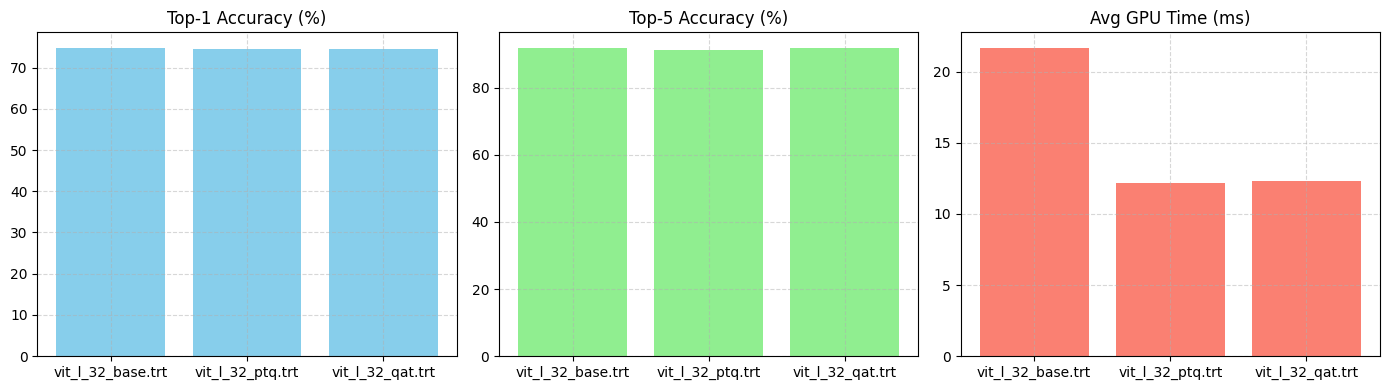

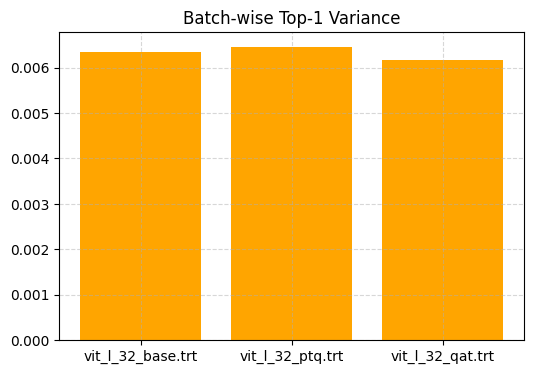

In [34]:
engine_paths = [
    "models/vit_l_32_base.trt",
    "models/vit_l_32_ptq.trt",
    "models/vit_l_32_qat.trt"
]

compare_models(engine_paths, val_dataloader)